In [1]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/kartikeyadatta/Documents/Projects/Naruto/code/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'seaborn'

In [92]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kartikeyadatta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load Model

In [93]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else "cpu"

In [94]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device = device,
        framework="pt"
    )
    return theme_classifier

In [95]:
theme_classifier = load_model(device)

Device set to use cpu


In [96]:
theme_list = ["friendship", "hope", "sacrifice", "Loss", "battle", "self development", "betrayal", "love", "dialogue"]

In [97]:
theme_classifier(
    "I gave him a right hook to the jaw.",
    theme_list,
    multilabel=True
)

{'sequence': 'I gave him a right hook to the jaw.',
 'labels': ['battle',
  'Loss',
  'sacrifice',
  'dialogue',
  'self development',
  'hope',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.43183720111846924,
  0.2033565491437912,
  0.10435514897108078,
  0.08809010684490204,
  0.08267572522163391,
  0.03386097401380539,
  0.03253179043531418,
  0.013948127627372742,
  0.009344393387436867]}

### Loading the  Dataset

In [98]:
files = glob('../data/Subtitles/*.ass')

In [99]:
files[:5]

['../data/Subtitles/Naruto Season 4 - 94.ass',
 '../data/Subtitles/Naruto Season 4 - 80.ass',
 '../data/Subtitles/Naruto Season 2 - 32.ass',
 '../data/Subtitles/Naruto Season 8 - 185.ass',
 '../data/Subtitles/Naruto Season 8 - 191.ass']

- Lets read the lines form the subtitles

In [100]:
with open(files[0], 'r') as file:
    lines = file.readlines()
    lines = lines[27:] # skip the first 27 lines as the dialogues in the subtitle folder are starting from line 27.
    lines = [','.join(line.split(',')[9:]) for line in lines]
    

In [101]:
lines[:2]

['We are Fighting Dreamers aiming high\n',
 "Fighting Dreamers\\Ndon't care what people think about them\n"]

In [102]:
lines = [ line.replace('\\N' , ' ')for line in lines]

In [103]:
lines[:2]

['We are Fighting Dreamers aiming high\n',
 "Fighting Dreamers don't care what people think about them\n"]

- As theme classifier has a maximum of 512 tokes we can not feed the whole subtitle to the model. We need to split the subtitle into chunks of data. 

In [104]:
" ".join(lines[:10])

"We are Fighting Dreamers aiming high\n Fighting Dreamers don't care what people think about them\n Fighting Dreamers follow what they believe\n Oli Oli Oli Oh! Just go my way\n Right here right now (Bang) Hit it straight like a line drive!\n Right here right now (Burn)\n Down a difficult road filled with endless struggles\n Where do you think you are going following someone else's map?\n An insightful crow comes along to tear up the map\n Now open your eyes and take a look at the truth (Yeah!)\n"

- Now lets try to get the episode number of our series.

In [105]:
int(files[0].split('-')[-1].split('.')[0].strip())

94

In [106]:
def load_subtitles_dataset(dataset_path):
    subtitles_path = glob(dataset_path+'/*.ass')
    
    scripts = []
    episode_num = []
    for path in subtitles_path:
        with open(path, 'r') as file:
            lines = file.readlines()
            lines = lines[27:] # skip the first 27 lines as the dialogues in the subtitle folder are starting from line 27.
            lines = [','.join(line.split(',')[9:]) for line in lines]
            
        lines = [ line.replace('\\N' , ' ')for line in lines]
        script = " ".join(lines)
        
        episode = int(path.split('-')[-1].split('.')[0].strip())
        
        scripts.append(script)
        episode_num.append(episode)
        
    df = pd.DataFrame.from_dict({"episode":episode_num, "script":scripts})
    return df

In [107]:
dataset_path = "../data/Subtitles"
df = load_subtitles_dataset(dataset_path)

In [108]:
df.head()

,episode,script
0,94,We are Fighting Dreamers aiming high\n Fightin...
1,80,We are Fighting Dreamers aiming high\n Fightin...
2,32,"Press down hard on the gas\n That’s right, the..."
3,185,"Rock away your existence,\n Shouting that you ..."
4,191,"Rock away your existence,\n Shouting that you ..."


### Lets try running our model

In [109]:
script = df.iloc[0]['script']
print(script)

We are Fighting Dreamers aiming high
 Fighting Dreamers don't care what people think about them
 Fighting Dreamers follow what they believe
 Oli Oli Oli Oh! Just go my way
 Right here right now (Bang) Hit it straight like a line drive!
 Right here right now (Burn)
 Down a difficult road filled with endless struggles
 Where do you think you are going following someone else's map?
 An insightful crow comes along to tear up the map
 Now open your eyes and take a look at the truth (Yeah!)
 There's nothing to lose, so let's GO!!!
 We are Fighting Dreamers aiming high
 Fighting Dreamers don't care what people think about them
 Fighting Dreamers follow what they believe
 Oli Oli Oli Oh! Just go my way
 Right here right now (Bang) Hit it straight like a line drive!
 Right here right now (Burn) We're gonna do it and do our best!
 Right here right now (Bang) Hit it straight like a line drive!
 Right here right now (Burn) We're gonna do it and do our best! BANG!
 My body movements have finally re

In [110]:

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/kartikeyadatta/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [111]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

["We are Fighting Dreamers aiming high\n Fighting Dreamers don't care what people think about them\n Fighting Dreamers follow what they believe\n Oli Oli Oli Oh!",
 'Just go my way\n Right here right now (Bang) Hit it straight like a line drive!',
 "Right here right now (Burn)\n Down a difficult road filled with endless struggles\n Where do you think you are going following someone else's map?"]

#### Batching the sentences with size of 20

In [112]:
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

In [113]:
script_batches[:3]

["We are Fighting Dreamers aiming high\n Fighting Dreamers don't care what people think about them\n Fighting Dreamers follow what they believe\n Oli Oli Oli Oh! Just go my way\n Right here right now (Bang) Hit it straight like a line drive! Right here right now (Burn)\n Down a difficult road filled with endless struggles\n Where do you think you are going following someone else's map? An insightful crow comes along to tear up the map\n Now open your eyes and take a look at the truth (Yeah!) There's nothing to lose, so let's GO!!! We are Fighting Dreamers aiming high\n Fighting Dreamers don't care what people think about them\n Fighting Dreamers follow what they believe\n Oli Oli Oli Oh! Just go my way\n Right here right now (Bang) Hit it straight like a line drive! Right here right now (Burn) We're gonna do it and do our best! Right here right now (Bang) Hit it straight like a line drive! Right here right now (Burn) We're gonna do it and do our best! BANG! My body movements have final

In [114]:
theme_output = theme_classifier(
    script_batches[:2], # taking the first two batches of sentences for classification
    theme_list,
    multilabel=True
)
theme_output

[{'sequence': "We are Fighting Dreamers aiming high\n Fighting Dreamers don't care what people think about them\n Fighting Dreamers follow what they believe\n Oli Oli Oli Oh! Just go my way\n Right here right now (Bang) Hit it straight like a line drive! Right here right now (Burn)\n Down a difficult road filled with endless struggles\n Where do you think you are going following someone else's map? An insightful crow comes along to tear up the map\n Now open your eyes and take a look at the truth (Yeah!) There's nothing to lose, so let's GO!!! We are Fighting Dreamers aiming high\n Fighting Dreamers don't care what people think about them\n Fighting Dreamers follow what they believe\n Oli Oli Oli Oh! Just go my way\n Right here right now (Bang) Hit it straight like a line drive! Right here right now (Burn) We're gonna do it and do our best! Right here right now (Bang) Hit it straight like a line drive! Right here right now (Burn) We're gonna do it and do our best! BANG! My body movemen

In [115]:
# Wrangle output into to batches of themes
themes ={}
for output in theme_output:
    for label, score in zip(output['labels'], output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [116]:
themes

{'dialogue': [0.21751122176647186, 0.1559881865978241],
 'battle': [0.20412367582321167, 0.21366335451602936],
 'self development': [0.1695924699306488, 0.09911166876554489],
 'sacrifice': [0.13159257173538208, 0.25838884711265564],
 'betrayal': [0.12379090487957001, 0.09235933423042297],
 'Loss': [0.06726245582103729, 0.04534672945737839],
 'hope': [0.05233101174235344, 0.042227137833833694],
 'friendship': [0.018233347684144974, 0.07056298106908798],
 'love': [0.015562324784696102, 0.022351745516061783]}

In [117]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)
    
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
        
    # Run the model
    theme_output = theme_classifier(
        script_batches[:2],     #[:2], to reduce stress on my CPU 😂
        theme_list,
        multilabel=True
    )
    theme_output
    
    # Wrangle output into to batches of themes
    themes ={}
    for output in theme_output:
        for label, score in zip(output['labels'], output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)
            
    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}
    return themes

In [118]:
df = df[:2] #same here stress on my CPU 😂
output_themes = df['script'].apply(get_themes_inference)

In [119]:
output_themes

0    {'dialogue': 0.18674970418214798, 'battle': 0....
1    {'sacrifice': 0.13815860822796822, 'battle': 0...
Name: script, dtype: object

In [120]:
print(pd.DataFrame(output_themes.tolist()).head())
theme_df = pd.DataFrame(output_themes.tolist())

   dialogue    battle  self development  sacrifice  betrayal      Loss  \
0  0.186750  0.208894          0.134352   0.194991  0.108075  0.056305   
1  0.275307  0.175646          0.121431   0.138159  0.084363  0.088783   

       hope  friendship      love  
0  0.047279    0.044398  0.018957  
1  0.056077    0.041647  0.018589  


In [121]:
theme_df

,dialogue,battle,self development,sacrifice,betrayal,Loss,hope,friendship,love
0,0.186750,0.208894,0.134352,0.194991,0.108075,0.056305,0.047279,0.044398,0.018957
1,0.275307,0.175646,0.121431,0.138159,0.084363,0.088783,0.056077,0.041647,0.018589


In [122]:
df[theme_df.columns] = theme_df
df

,episode,script,dialogue,battle,self development,sacrifice,betrayal,Loss,hope,friendship,love
0,94,We are Fighting Dreamers aiming high\n Fightin...,0.186750,0.208894,0.134352,0.194991,0.108075,0.056305,0.047279,0.044398,0.018957
1,80,We are Fighting Dreamers aiming high\n Fightin...,0.275307,0.175646,0.121431,0.138159,0.084363,0.088783,0.056077,0.041647,0.018589


### Visualize Output

In [123]:
df = df.drop('dialogue', axis=1)
df

,episode,script,battle,self development,sacrifice,betrayal,Loss,hope,friendship,love
0,94,We are Fighting Dreamers aiming high\n Fightin...,0.208894,0.134352,0.194991,0.108075,0.056305,0.047279,0.044398,0.018957
1,80,We are Fighting Dreamers aiming high\n Fightin...,0.175646,0.121431,0.138159,0.084363,0.088783,0.056077,0.041647,0.018589


In [124]:
theme_output = df.drop(['episode', 'script'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,battle,0.384539
1,self development,0.255783
2,sacrifice,0.333149
3,betrayal,0.192438
4,Loss,0.145087
5,hope,0.103356
6,friendship,0.086046
7,love,0.037546


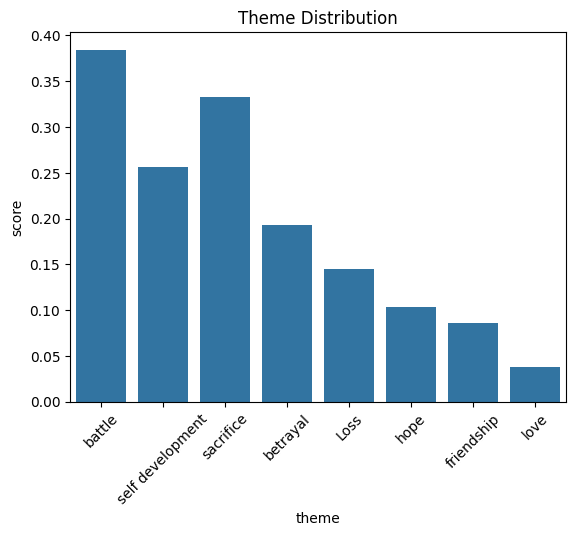

In [125]:
sns.barplot(data=theme_output, x='theme', y='score')
plt.xticks(rotation=45)
plt.title('Theme Distribution')
plt.show()